In this notebook, we study an aviation events dataset from [kaggle]('https://www.kaggle.com/khsamaha/aviation-accident-database-synopses'). 

In [271]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from tqdm.notebook import tqdm
from numpy import random
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


## 1- Downloading the dataset

In [4]:
ds_filepath = '.\\data\\aviation-accident-database-synopses\\AviationData.csv'
states_filepath = '.\\data\\aviation-accident-database-synopses\\USState_Codes.csv'

if not(os.path.exists(ds_filepath)):
    ds_url =  'https://www.kaggle.com/khsamaha/aviation-accident-database-synopses'
    od.download_kaggle_dataset(ds_url,'.\data')

aviation_ds = pd.read_csv(ds_filepath, encoding='ISO-8859-1')
states_ds = pd.read_csv(states_filepath, encoding='ISO-8859-1')


We downloaded two csv files. The `states_ds` dataset contains a list of US states and theit two-letters abbreviations. The main dataset is `aviation_ds`. Let's explore it !

In [5]:
print('Columns :')
print(aviation_ds.columns)
print('\n')
aviation_ds.info()

Columns :
Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'LOCATION', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85976 entries, 0 to 85975
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                85976 non-null  object 
 1   Investigation.Type      85963 non-null  object 
 2   Accident.Number         85976 non-

This dataset contains more than 85k records of aviation incidents/accidents. Each event is described using multiple parameters. Let's check the first column of interest. 

In [6]:
aviation_ds['Investigation.Type'].unique()

array(['Accident', 'Incident', nan], dtype=object)

The investigations are grouped into two (or three if we consider the 'nan' class). **Incident** refer to an unexpected event, that causes safety concerns. **Accidents** are incidents that invlove injuries or deaths.
  
    
For every event, a date is provided through `Event.date` column. Let's convert it to date/time data type :

In [7]:
aviation_ds['Event.Date'] = pd.to_datetime(aviation_ds['Event.Date'])
aviation_ds['Event.Date'].describe()

C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                   85976
unique                  14117
top       2000-07-08 00:00:00
freq                       25
first     1948-10-24 00:00:00
last      2021-02-16 00:00:00
Name: Event.Date, dtype: object

The first recorded event happened on 1948, so more than 73 years ago. Let's check which weekdays and months are more represented in the data.

<AxesSubplot:xlabel='Event.Month', ylabel='Count'>

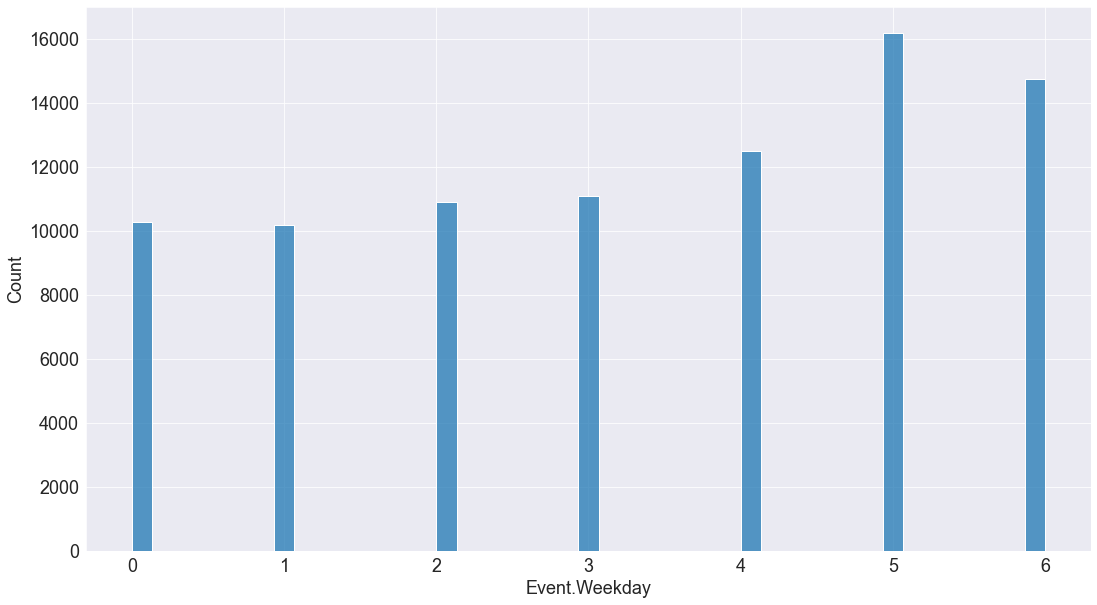

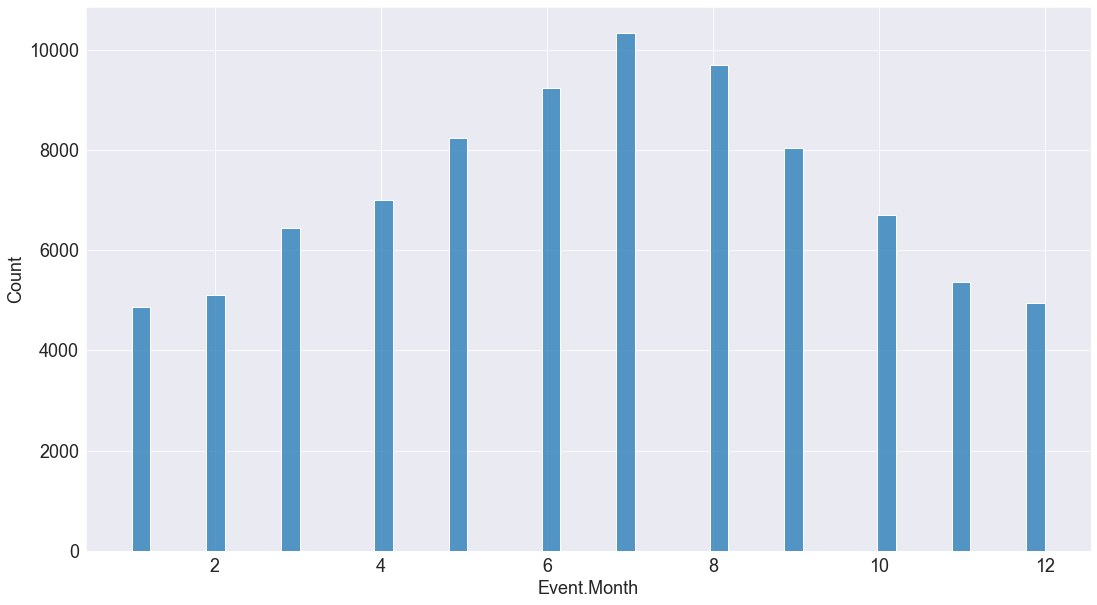

In [8]:
aviation_ds['Event.Weekday']=aviation_ds['Event.Date'].dt.weekday # 0 is monday, 6 is sunday
aviation_ds['Event.Month']=aviation_ds['Event.Date'].dt.month # 
sns.histplot(x ='Event.Weekday', data = aviation_ds, stat='count', )
plt.figure()
sns.histplot(x ='Event.Month', data = aviation_ds, stat='count')

The first histogram shows that events happen more often on *weekends*. This is expected due to the large number of amateur pilots flying only on weekends. We will see later the relationship between the type of aircraft and the probablity of accidents/incidents.  
The second plot shows that events are more likely to happen during summertime in the northern hemisphere. This is probably due to the largest aviation activity in this region (north America, Europe and Asia). Another reason would be that our dataset has more entries from the USA, as we will see later.  
Let's consider the columns `LOCATION` and `Country`. First we have to fix a small problem about datatype:

In [9]:
aviation_ds.dtypes


Event.Id                          object
Investigation.Type                object
Accident.Number                   object
Event.Date                datetime64[ns]
LOCATION                          object
Country                           object
Latitude                         float64
Longitude                        float64
Airport.Code                      object
Airport.Name                      object
Injury.Severity                   object
Aircraft.damage                   object
Aircraft.Category                 object
Registration.Number               object
Make                              object
Model                             object
Amateur.Built                     object
Number.of.Engines                float64
Engine.Type                       object
FAR.Description                   object
Schedule                          object
Purpose.of.flight                 object
Air.carrier                       object
Total.Fatal.Injuries             float64
Total.Serious.In

We need the `Country` column to be of text or string datatype.

In [10]:
aviation_ds['Country']=aviation_ds['Country'].astype(str)
x = aviation_ds.groupby('Country')['Event.Id'].count().sort_values(ascending=False).head(10)
print(x)

Country
United States     80132
nan                 507
Canada              318
Mexico              309
Brazil              305
United Kingdom      282
Australia           277
France              209
Bahamas             208
Germany             194
Name: Event.Id, dtype: int64


In [30]:
sns.barplot(x = x.index, y = x.values);

Error in callback <function flush_figures at 0x000002897B2C78B8> (for post_execute):


KeyboardInterrupt: 

Most of the dataset describes events that happend in the USA.  
Using the `LOCATION` column, we can extract the states (when the location is in the USA):

In [12]:

def get_state(text):
    return str(text)[-2:]

aviation_ds['Event.State'] = aviation_ds[aviation_ds['Country']=='United States']['LOCATION'].apply(get_state)
aviation_ds['Event.State'].unique() 

array(['WI', 'CB', 'AK', 'FL', 'WY', 'MO', 'VA', 'AZ', 'UT', 'SC', 'CA',
       'ID', 'MI', 'MA', 'LA', 'CO', 'TN', 'IA', 'WA', 'TX', 'MT', 'NC',
       'OR', 'GA', 'NV', 'AL', 'NY', 'OK', 'AR', 'NH', 'MN', 'PA', 'MS',
       'IL', 'NE', 'ME', 'SD', 'IN', 'KS', 'DE', 'NJ', 'KY', 'OH', 'ND',
       'HI', 'NM', 'MD', 'CT', 'RI', nan, 'VT', 'PR', 'O,', 'an', 'WV',
       'UN', 'GM', 'VI', 'MP', 'AO', 'PO', 'GU', 'MH', 'FN', 'DC', 'ON'],
      dtype=object)

In this section, we consider the `Injury.Severity` column.

In [13]:
aviation_ds['Injury.Severity'].unique()

array(['Fatal', 'Minor', 'Non-Fatal', 'Siruose', nan, 'Unavailable',
       'Incident', 'Fatal(1)', 'Fatal(2)', 'Fatal(8)', 'Fatal(5)',
       'Fatal(3)', 'Fatal(4)', 'Fatal(9)', 'Fatal(176)', 'Fatal(7)',
       'Fatal(29)', 'Fatal(6)', 'Fatal(10)', 'Fatal(11)', 'Fatal(14)',
       'Fatal(41)', 'Fatal(157)', 'Fatal(188)', 'Fatal(112)', 'Fatal(71)',
       'Fatal(12)', 'Fatal(39)', 'Fatal(16)', 'Fatal(66)', 'Fatal(62)',
       'Fatal(23)', 'Fatal(224)', 'Fatal(150)', 'Fatal(43)', 'Fatal(162)',
       'Fatal(58)', 'Fatal(295)', 'Fatal(239)', 'Fatal(33)', 'Fatal(50)',
       'Fatal(21)', 'Fatal(19)', 'Fatal(153)', 'Fatal(127)', 'Fatal(28)',
       'Fatal(77)', 'Fatal(42)', 'Fatal(158)', 'Fatal(103)', 'Fatal(89)',
       'Fatal(90)', 'Fatal(152)', 'Fatal(228)', 'Fatal(17)', 'Fatal(13)',
       'Fatal(24)', 'Fatal(88)', 'Fatal(65)', 'Fatal(154)', 'Fatal(30)',
       'Fatal(20)', 'Fatal(40)', 'Fatal(57)', 'Fatal(199)', 'Fatal(114)',
       'Fatal(102)', 'Fatal(96)', 'Fatal(49)', 'Fatal(124)'

There's already a column detailing the number of fatal injuries, so the number between bracket is not necessary. 

In [14]:
aviation_ds['Total.Fatal.Injuries']

0        2.0
1        4.0
2        0.0
3        0.0
4        0.0
        ... 
85971    1.0
85972    2.0
85973    3.0
85974    4.0
85975    2.0
Name: Total.Fatal.Injuries, Length: 85976, dtype: float64

We can fix this by applying a function that removes the brackets and the number. We will replace `Siruose` by `Serious` 

In [15]:
def remove_fatal(text):
    if 'Fatal(' in text:
        return 'Fatal'
    elif text == 'Siruose':
        return 'Serious'
    else:
        return text
aviation_ds['Injury.Severity'] = aviation_ds['Injury.Severity'].astype(str)
aviation_ds['Injury.Severity'] = aviation_ds['Injury.Severity'].apply(remove_fatal)
aviation_ds['Injury.Severity'] .unique()

array(['Fatal', 'Minor', 'Non-Fatal', 'Serious', 'nan', 'Unavailable',
       'Incident'], dtype=object)

Now we can drow a plot of this information :

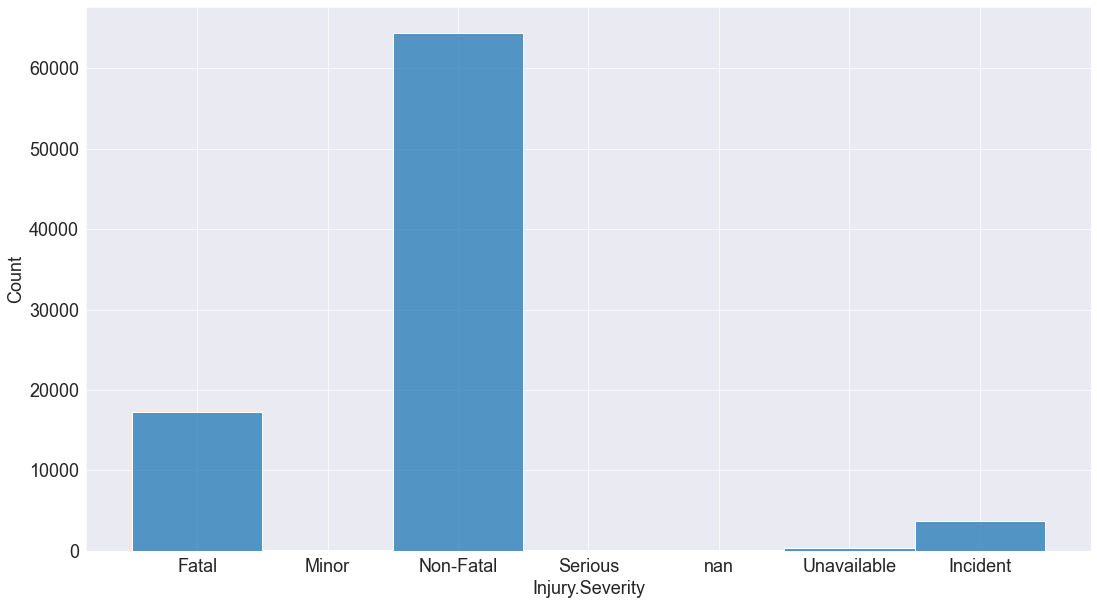

In [16]:
sns.histplot(x ='Injury.Severity', data = aviation_ds );

Now we display the column `Aircraft.damage`

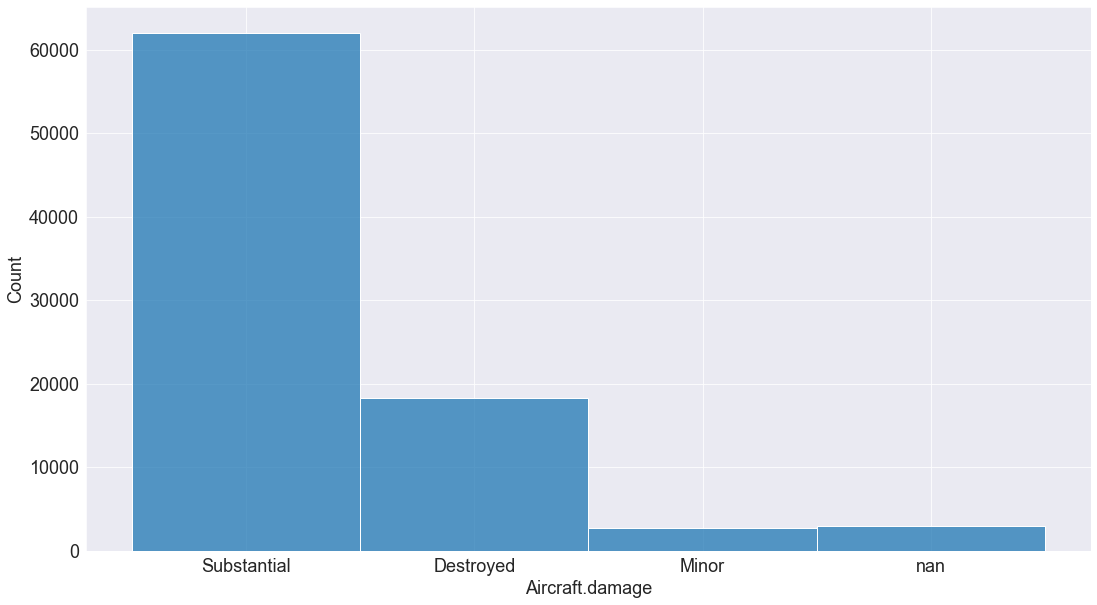

In [17]:
aviation_ds['Aircraft.damage'] =aviation_ds['Aircraft.damage'].astype(str)
sns.histplot(x = 'Aircraft.damage', data = aviation_ds);

Although the most common severity of injury is *non-fatal*, most of the events result in serious damages to aircraft.  
Let's see which aircraft categories are more affected by events:

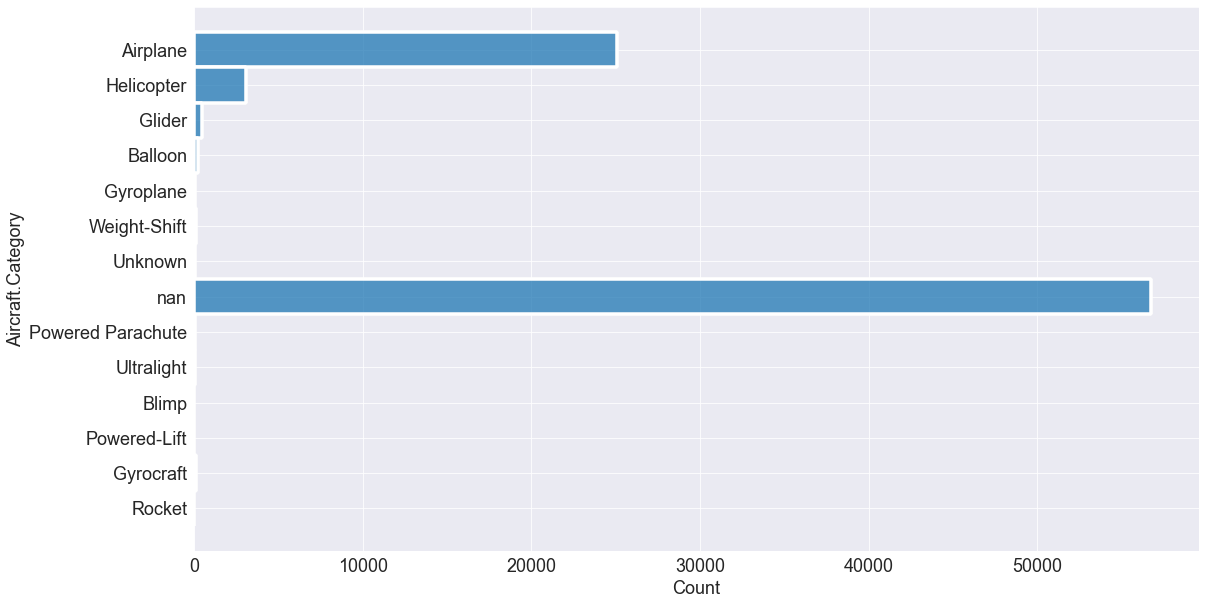

In [18]:
aviation_ds['Aircraft.Category'] = aviation_ds['Aircraft.Category'].astype(str)
sns.histplot(y = 'Aircraft.Category', data = aviation_ds);

Airplanes are more represented than other aircraft types. That being said, the misrepresented events **nan**  are more numerous than all other classes. This category has a lot of missing data.  
Next are the columns `Make`, `Model`. 

In [19]:
aviation_ds['Make'] =aviation_ds['Make'].astype(str)
aviation_ds['Model'] =aviation_ds['Model'].astype(str)


In [20]:
print(aviation_ds['Make'].unique())
print(aviation_ds['Model'].unique())


['Velocity' 'Bell' 'Maule' ... 'Rockwell Comdr' 'Bell/textron'
 'Sons Mustang']
['Vtwin' '206' 'M-6-235' ... '23-250' '305 (L-19)' 'WCS-222 (BELL 47G)']


In the column `Amateur.Built`, a special category of aircraft is shown. In general, these aircraft are used for training or tourism purposes. Let's look for more details.

In [21]:
aviation_ds['Amateur.Built'].describe()

count     85296
unique        2
top          No
freq      77058
Name: Amateur.Built, dtype: object

We will convert this column to a `boolean` data type.

In [22]:
def conv_str2bool(text):
    if text=='No':
        return False
    elif text=='Yes':
        return True
    else:
        return None

aviation_ds['Amateur.Built'] = aviation_ds['Amateur.Built'].astype(str)
aviation_ds['Amateur.Built'] = aviation_ds['Amateur.Built'].apply(conv_str2bool)
aviation_ds['Amateur.Built'].unique()


array([False, True, None], dtype=object)

First, let's plot the frequency of aircraft events involving amateur-built machines. 

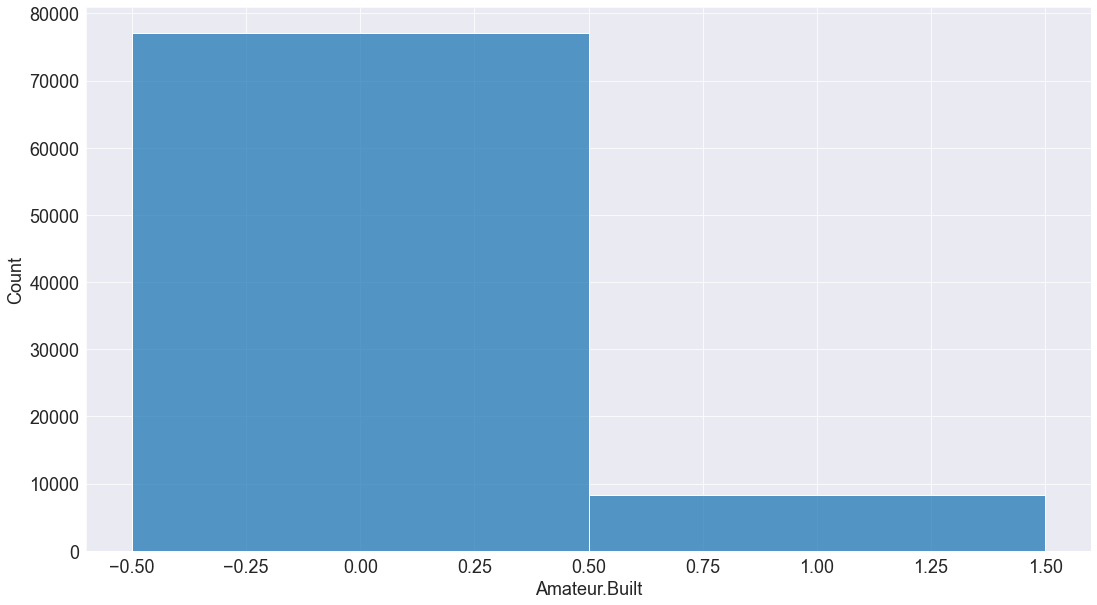

In [23]:
sns.histplot(x ='Amateur.Built', data = aviation_ds, bins=[False, True]);

In [24]:
print(aviation_ds['Amateur.Built'].describe())

count     85296
unique        2
top       False
freq      77058
Name: Amateur.Built, dtype: object


77058 events out of 85296 events do not involve amateur-built aircraft. Is there a relationship between the build and the time period of events ?

<AxesSubplot:ylabel='Count'>

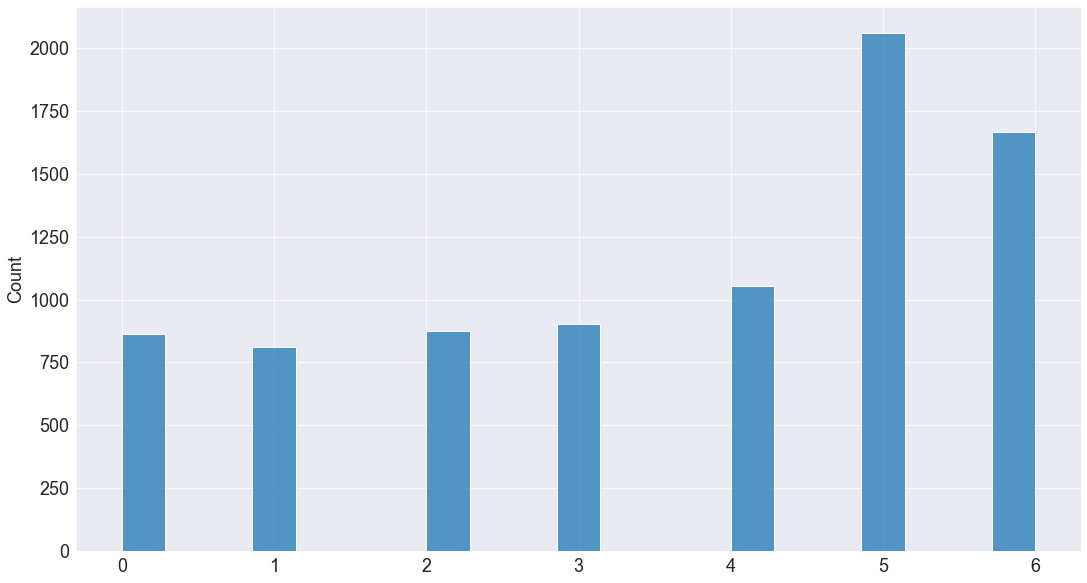

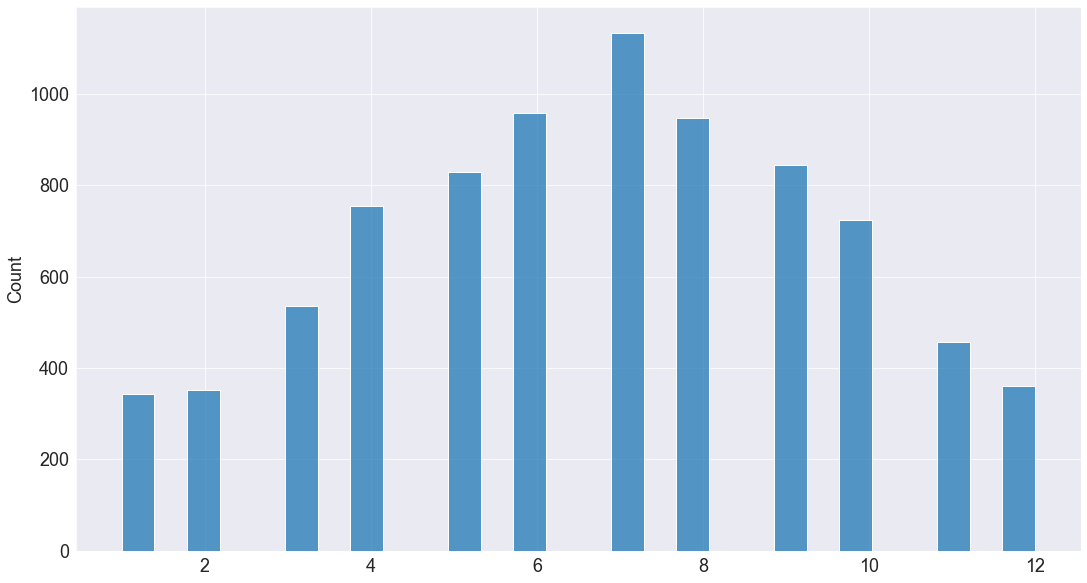

In [25]:
x = aviation_ds[aviation_ds['Amateur.Built'] == True]['Event.Weekday']
y = aviation_ds[aviation_ds['Amateur.Built'] == True]['Event.Month']
sns.histplot(x =x.values)
plt.figure()
sns.histplot(x = y.values)

As we expected, this category of aircraft is mainly used during weekends and summertime. In the next plot, we analyse the events related to `Amateur.Built` aircraft events.

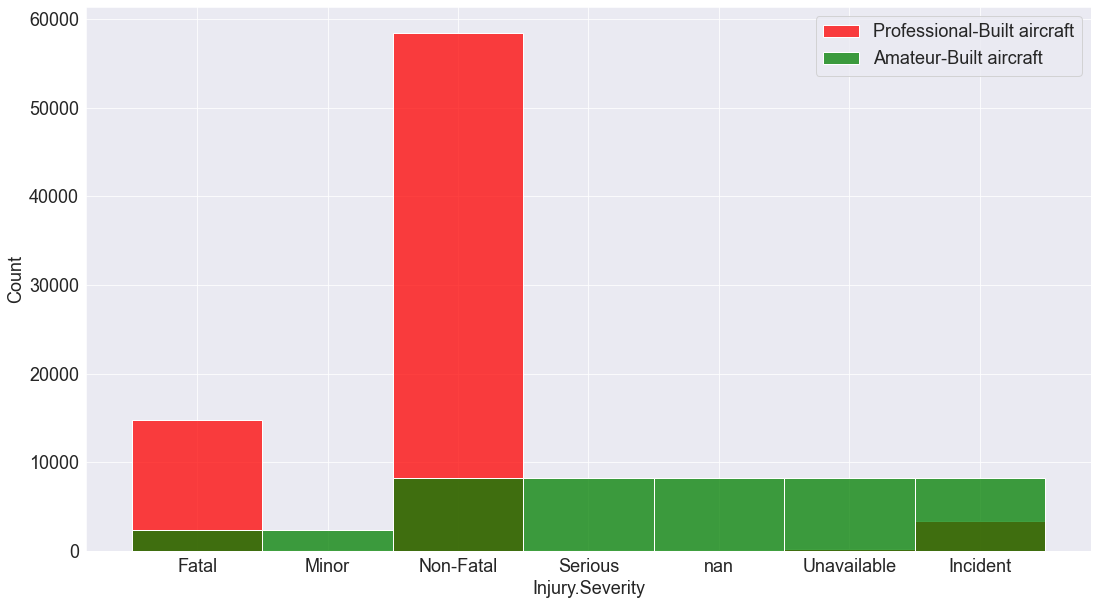

In [26]:
sns.histplot(x ='Injury.Severity', data =  aviation_ds[aviation_ds['Amateur.Built'] == False], color ='r', label = 'Professional-Built aircraft');
sns.histplot(x ='Injury.Severity', data =  aviation_ds[aviation_ds['Amateur.Built'] == True] , color='g', label = 'Amateur-Built aircraft',cumulative=True );
plt.legend();


`Amateur.Built` aircraft are less common. This is the main reason the events count, and fatal injuries are lower. The next interesting parameter is the number of engines.

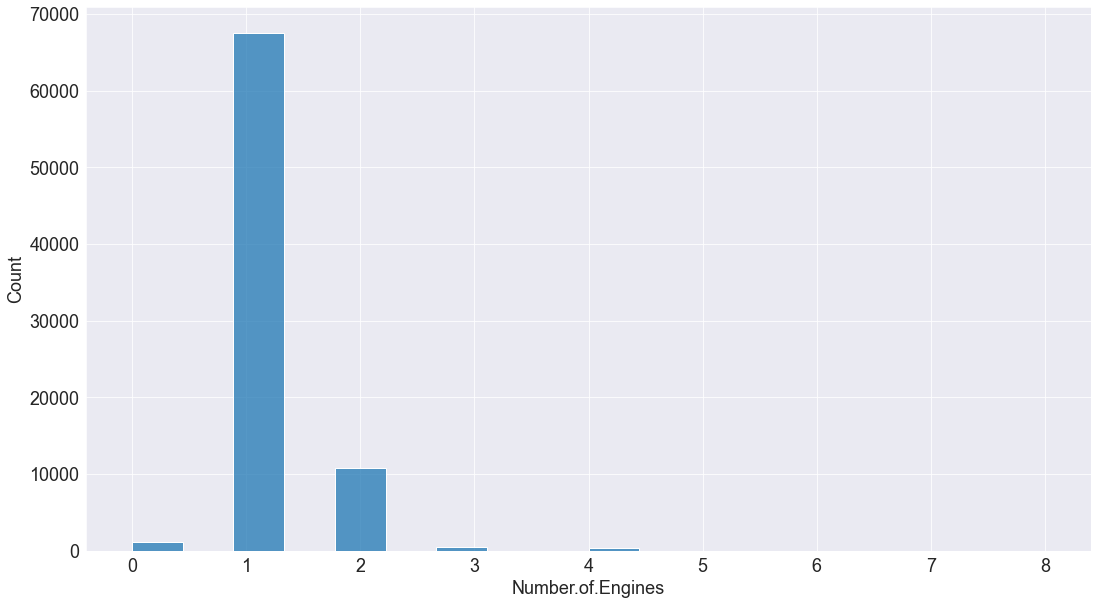

In [34]:
sns.histplot(x = 'Number.of.Engines', data = aviation_ds);

As we can observe, the single engine aircraft are the most affected by accidents/incidents. One possible explanation is that most small and amateur aircraft are single-engine. The second possible reason is that -in case of an engine loss- aircraft with more than one engine could continue to fly to a safe destination, whereas single-engine aircraft must land immediatly.  
Using the column `Total.Fatal.Injuries`, we display the events with the most fatal injuries.

In [79]:
x = aviation_ds['Total.Fatal.Injuries'].sort_values(ascending = False).head(10)
print(x)

45091    349.0
45090    349.0
10358    295.0
63894    270.0
34208    265.0
72376    256.0
10999    239.0
45865    230.0
41165    229.0
19463    228.0
Name: Total.Fatal.Injuries, dtype: float64


We can show more data about these accidents.

In [97]:
aviation_ds.iloc[x.index][['Country','Model', 'Event.Date']]

,Country,Model,Event.Date
45091,India,747-168,1996-11-12
45090,India,TU-154,1996-11-12
10358,Ukraine,777 - 206,2014-07-17
63894,United Kingdom,747-121,1988-12-21
34208,United States,A300B4-605R,2001-11-12
72376,Canada,DC-8-63,1985-12-12
10999,Malaysia,777 - 206,2014-03-08
45865,United States,747-131,1996-07-17
41165,Canada,MD-11,1998-09-02
19463,France,A330,2009-06-01


As we can expect, all these accidents were related to heavy aircraft (Boeing 747,777 ,Airbus300, MD-11 etc). The 2 first events are -in fact- one mid-air collision that happened in 1996 between a **Saudi Airline **B747 and a **Kazakhstan Airlines** Illyushin II-76 TD [read here](https://en.wikipedia.org/wiki/1996_Charkhi_Dadri_mid-air_collision).  
This lead to an observation : we can retrieve mid-air collisions by looking at the date and location of accidents.

In [205]:
date_ds = aviation_ds.groupby(['Event.Date']).count().reset_index()
dates = date_ds[date_ds['Event.Id']>1]['Event.Date']
dates

7       1982-01-01
8       1982-01-02
9       1982-01-03
10      1982-01-04
11      1982-01-05
           ...    
14100   2021-01-26
14105   2021-01-31
14106   2021-02-02
14109   2021-02-05
14111   2021-02-08
Name: Event.Date, Length: 13436, dtype: datetime64[ns]

Those are the dates with two or more events. 

In [248]:
mid_air_collisions = []
for date in tqdm(dates):
    x = aviation_ds[aviation_ds['Event.Date']==date].groupby('LOCATION').count()
    for ind, y in enumerate(x['Event.Id']):
        if y>1:
            mid_air_collisions.append((date , x.index[ind]))

In [268]:
mid_air_collisions[:50]

[(Timestamp('1982-01-19 00:00:00'), 'ROCKPORT, TX'),
 (Timestamp('1982-01-23 00:00:00'), 'NEWPORT RICHEY, FL'),
 (Timestamp('1982-01-23 00:00:00'), 'VICTORVILLE, CA'),
 (Timestamp('1982-02-06 00:00:00'), 'MEDFORD, OR'),
 (Timestamp('1982-02-06 00:00:00'), 'SAN JOSE, CA'),
 (Timestamp('1982-02-07 00:00:00'), 'W. OF HOMESTEAD, FL'),
 (Timestamp('1982-02-08 00:00:00'), 'NASHVILLE, TN'),
 (Timestamp('1982-03-06 00:00:00'), 'HALF MOON BAY, CA'),
 (Timestamp('1982-03-11 00:00:00'), 'NASHVILLE, TN'),
 (Timestamp('1982-03-13 00:00:00'), 'GLENDALE, AZ'),
 (Timestamp('1982-04-15 00:00:00'), 'TULARE, CA'),
 (Timestamp('1982-04-25 00:00:00'), 'NEW YORK, NY'),
 (Timestamp('1982-05-01 00:00:00'), 'CAMARILLO, CA'),
 (Timestamp('1982-05-01 00:00:00'), 'MARIETTA, GA'),
 (Timestamp('1982-05-01 00:00:00'), 'NORTH LAS VEGAS, NV'),
 (Timestamp('1982-05-12 00:00:00'), 'SANFORD, ME'),
 (Timestamp('1982-05-28 00:00:00'), 'EVANSVILLE, IN'),
 (Timestamp('1982-06-02 00:00:00'), 'SANTA CRUZ, CA'),
 (Timestamp('19

We can check events associated with these dates/locations. Note that we assume that two events happening in the same location, the same day are considered to be mid-air collisions. We couldn't confirmn that using LAT/LONG, due to the lack of this information in multiple cases.

In [303]:
print('Number of mid-air collision events is {}, out of {} events\n'.format(len(mid_air_collisions), len(aviation_ds)))
i = random.randint(len(mid_air_collisions))
event  = mid_air_collisions[i]
date = event[0]
location = event[1]
print('Here is an event that happened in {} on {}'.format(location, date))
df1 = aviation_ds[aviation_ds['Event.Date']==date]
result = df1[df1['LOCATION']==location]
result[['Make', 'Model', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']]

Number of mid-air collision events is 1241, out of 85976 events

Here is an event that happened in SAN DIEGO, CA on 2003-03-16 00:00:00


,Make,Model,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
31664,Schweizer,SGS 1-34,NaN,NaN,NaN,1.0
31665,Schleicher,ASW-20,NaN,NaN,NaN,1.0
